# Random Network Simulations

In [1]:
import tellurium as te
from libsbml_draw import SBMLlayout
import random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Load Models

In [39]:
r_15_species = te.loadSBMLModel(r"..\networks\15_species_network.xml")
r_8_species = te.loadSBMLModel(r"..\networks\8_species_network.xml")

In [6]:
ant_15_species = te.sbmlToAntimony(r"..\networks\15_species_network.xml")
ant_8_species = te.sbmlToAntimony(r"..\networks\8_species_network.xml")

### Model Details

In [7]:
print(ant_8_species)

// Created by libAntimony v2.12.0.3
model *doc0()

  // Compartments and Species:
  compartment compartment_;
  species S1 in compartment_, S2 in compartment_, S3 in compartment_, S4 in compartment_;
  species S5 in compartment_, S6 in compartment_, S7 in compartment_, S8 in compartment_;
  species $S_in in compartment_, S_out in compartment_;

  // Reactions:
  r1: $S_in => S7; S2*(kf_J1*S_in/K1_J1 - kr_J1*S7/K2_J1)/(1 + S_in/K1_J1 + S7/K2_J1);
  r2: S8 => S_out; S5*(kf_J2*S8/K1_J2 - kr_J2*S_out/K2_J2)/(1 + S8/K1_J2 + S_out/K2_J2);
  r3: S_out => S8; S1*(kf_J3*S_out/K2_J3 - kr_J3*S8/K1_J3)/(1 + S_out/K2_J3 + S8/K1_J3);
  r4: S3 => S8 + S5; kf_J4*S3 - kr_J4*S8*S5;
  r5: S7 => S6 + S4; kf_J5*S7 - kr_J5*S6*S4;
  r6: S4 + S6 => S3; kf_J6*S4*S6 - kr_J6*S3;

  // Species initializations:
  S1 = 0.430570015589594/compartment_;
  S2 = 0.244570243558996/compartment_;
  S3 = 28.324643372651/compartment_;
  S4 = 5.92313871803477/compartment_;
  S5 = 12.517567535823/compartment_;
  S6 = 5.9251357

### Model Networks

updating network


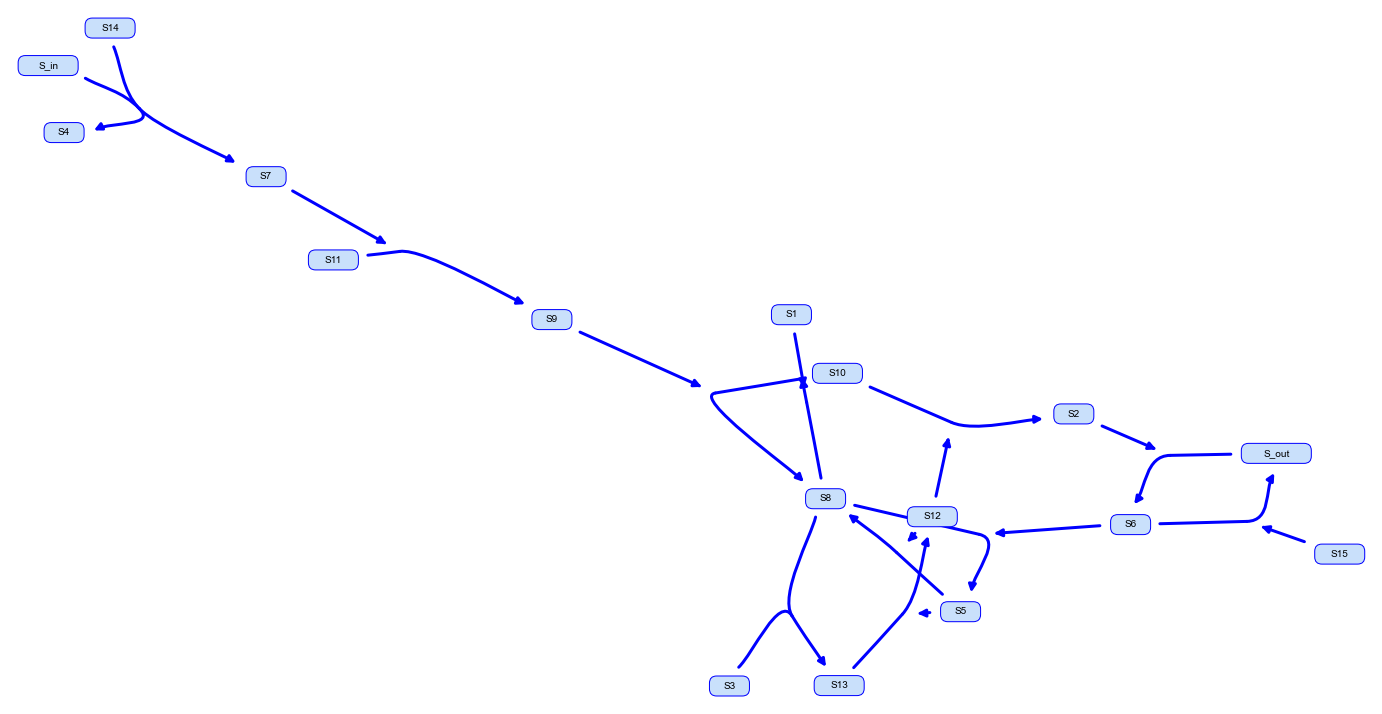

In [12]:
s = SBMLlayout(r"..\networks\15_species_network.xml")
s.drawNetwork(r"..\networks\15_species_network.pdf", show=False)

#### Reaction r1

$$S_{in} + S14 => S7 + S4$$ $$kf_{J1}*S_{in}*S14 - kr_{J1}*S7*S4$$

updating network


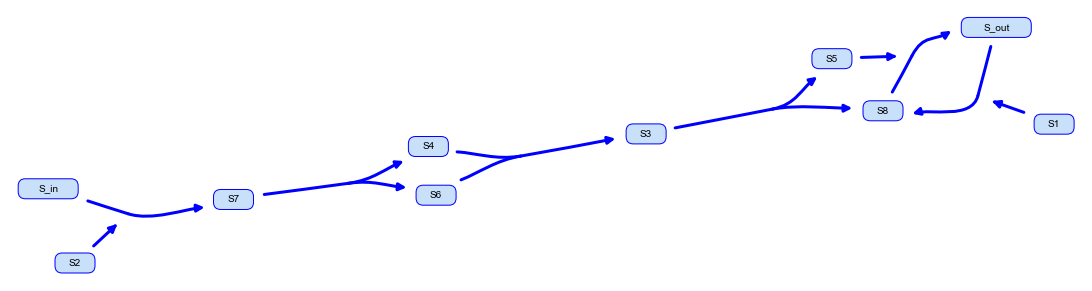

In [14]:
s = SBMLlayout(r"..\networks\8_species_network.xml")
s.drawNetwork(r"..\networks\8_species_network-1.pdf", show=False)

### Initial Model Parameters

We have models with parameters initialized at steady state. We need to adjust these in order to start system in unsteady state (realistic bio scenario).

In [15]:
## How to extract species starting amounts
r_8_species.model['S1']

0.430570015589594

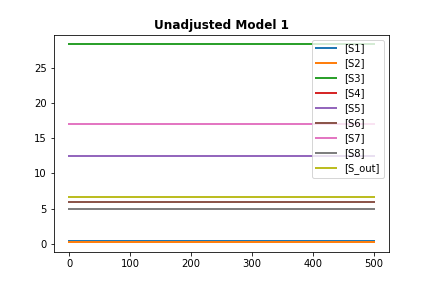

In [16]:
## System at steady state
result_1 = r_8_species.simulate(0, 500)
r_8_species.plot(result_1, title = 'Unadjusted Model 1')

### Adjust Parameters

How to adjust parameters

Concentration vs Amount

r.model['init([S1])'] - Set Concentration

r.model['init(S1)'] - Set Amount

In [17]:
## Adjust all params
r_8_species.model.setFloatingSpeciesInitAmounts([2.6, 7,8])
r_8_species.model.setFloatingSpeciesInitConcentrations([1.2, 34.5])

2

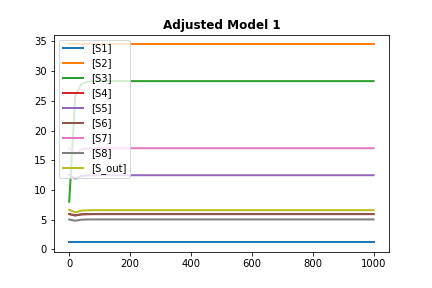

In [18]:
result_1 = r_8_species.simulate(0, 1000)
r_8_species.plot(result_1, title = 'Adjusted Model 1')

In [19]:
## Reset paramters back to initial values
r_8_species.resetToOrigin()

### Simulate Data

Create a dataset by simulating the system with different starting parameters. Take the final value of the system at steady state (t=1000). Collect into dataframe. Class lets you simulate different starting values for species and rates. Set specific species or all. Rates function isn't finished/not sure it will work.

In [43]:
class SimulateData:
    
    """
    Class to simulate data for Tellurium SBML network. Can adjust different species or 
    parameters using ODE or SDE simulation.
    ---
    sbml: Tellurium sbml graph
    """
    
    def __init__(self, sbml):
        
        self.sbml = sbml
        self.sbml.resetToOrigin()
        
    def sim_with_species_adj(self, species_adjust = list(), sim_type = 'SDE', n = 1000, distribution = 'Gaussian'):
        """
        Function to simulate data with different starting species concentrations
        ---

        species: list of species to adjust starting points, if blank then adjusts all starting points
        sim_type: one of either SDE or ODE used for simulation.
        n: number of simulations to make
        distribution: What type of distribution starting points should be sampled from
        """
        
        self.species_adjust = species_adjust
        self.distribution = distribution
        self.sim_type = sim_type
        
        if self.distribution == 'Gaussian':
            dist = np.random.normal
        else:
            print('Only normal distributions supported')
            return
        
        self.sim_type = self.sim_type.upper()
        if self.sim_type not in ['SDE', 'ODE']:
            print('sim_type must be one of the following: sde, ode')
            return
        
        ## Initialize species parameters and lists for simulated values
        dataset = list()
        S_in = list()
        params = self.sbml.getFloatingSpeciesConcentrationIds()
        params = ['S_in'] + params ## S_in not included in param listing
        
        ## TODO: Determine best way to adjust species. How to define mean
        ##        and variance. Discrete value or based on initial params.
        for x in range(0, n):
            if len(self.species_adjust) > 0:
                for s in self.species_adjust:
                    #temp_mean = sbml.model['init([{0}])'.format(s)]
                    if s == 'S_in':
                        temp_mean = random.randint(2,10)
                        new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                        while new_val < 0:
                            new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                        self.sbml.model[s] = new_val
                    else:
                        temp_mean = random.randint(2,10)
                        new_val = dist(temp_mean, temp_mean / 3)
                        while new_val < 0:
                            new_val = dist(temp_mean, temp_mean / 3)
                        self.sbml.model['init([{0}])'.format(s)] = new_val
                S_in.append(self.sbml.model['S_in'])
            else:
                for s in params:
                    #temp_mean = sbml.model['init({0})'.format(s)]
                    if s == 'S_in':
                        temp_mean = random.randint(2,10)
                        new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                        while new_val < 0:
                            new_val = dist(self.sbml.model[s], self.sbml.model[s] / 3)
                        self.sbml.model[s] = new_val
                    else:
                        temp_mean = random.randint(2,10)
                        new_val = dist(temp_mean, temp_mean / 3)
                        while new_val < 0:
                            new_val = dist(temp_mean, temp_mean / 3)
                        self.sbml.model['init({0})'.format(s)] = new_val
                S_in.append(self.sbml.model['S_in'])
            
            ## Simulate data depending on sim_type
            if self.sim_type == 'ODE':
                model_results = self.sbml.simulate(0, 1000)
                temp_result = model_results[-1]
            else:
                self.sbml.setSeed(1234)
                model_results = self.sbml.gillespie(0, 1000)
                temp_result = model_results[-1]
                                 
            dataset.append(temp_result)
            self.final_model = model_results
            self.sbml.resetToOrigin()
        
        ## Push results to pandas dataframe
        params.pop(0)
        dataset = pd.DataFrame(dataset, columns = ['time'] + params)
        dataset.loc[:, '[S_in]'] = S_in
        
        self.sim_results = dataset

    def sim_with_rate_adj(self, rate_adjust = list(), sim_type = 'SDE', n = 1000):
        """
        Function to simulate data with different starting parameters
        NOTE: function not finished. Need to determine correct distriubtion to intialize parameters at.
        ---

        species: list of species to adjust starting points, if blank then adjusts all starting points
        sim_type: one of either SDE or ODE used for simulation.
        n: number of simulations to make
        """

        self.rate_adjust = rate_adjust
        self.sim_type = sim_type
        
        ## Initialize species parameters and lists for simulated values
        dataset = list()
        rates = self.sbml.getReactionIds()

        for x in range(0, n):
            if len(self.rate_adjust) > 0:
                for r in self.rate_adjust:
                    new_rate = np.random.binomial([.01, .1, .25, .5, .75, .9, .99], 
                                                  [.05, .15, .2, .2, .2, .15,.05])
                    self.sbml.model.model[r] = new_rate
            else:
                for r in rates:
                    new_rate = np.random.binomial([.01, .1, .25, .5, .75, .9, .99], 
                                                  [.05, .15, .2, .2, .2, .15,.05])
                    self.sbml.model.model[r] = new_rate
            
            ## Simulate data depending on sim_type
            if self.sim_type == 'ODE':
                model_results = self.sbml.simulate(0, 1000)
                temp_result = model_results[-1]
            else:
                look_back = 100 ## time stamps to avg over for final results
                model_results = self.sbml.gillespie(0, 1000)
                temp_result = model_results[-look_back:].mean(axis = 0)
            
            dataset.append(temp_result)
            self.final_model = model_results
            self.sbml.resetToOrigin()
        
        params = self.sbml.getFloatingSpeciesConcentrationIds()
        dataset = pd.DataFrame(dataset, columns = ['time'] + params)
        
        self.sim_results = dataset
        
        
    def plot_last_sim(self):
        
        """
        Simple function to plot the results of the final simulation ran.
        """
        r_8_species.plot(self.final_model, title = 'Final Model ({0})'.format(self.sim_type))
        

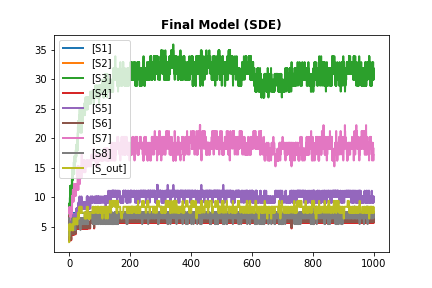

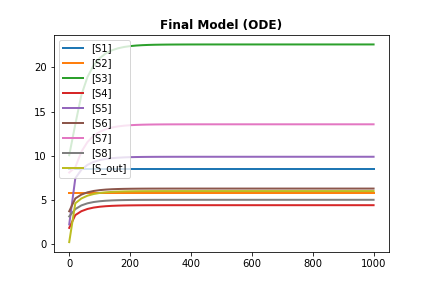

In [26]:
r_8_sim = SimulateData(r_8_species)
r_8_sim.sim_with_species_adj(species_adjust = [], sim_type = 'sde')
sde_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

r_8_sim.sim_with_species_adj(species_adjust = [], sim_type = 'ode')
ode_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

Text(0.5, 0.98, 'S7 vs S_out')

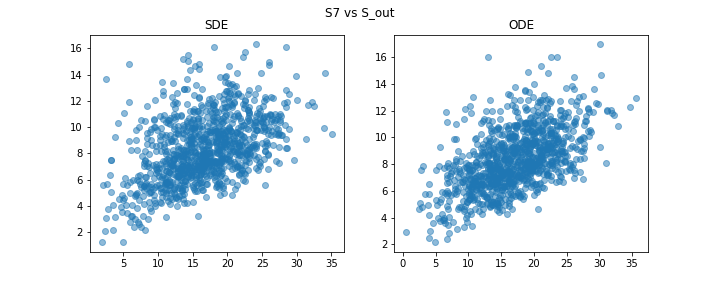

In [27]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].scatter(sde_results['[S7]'], sde_results['[S_out]'], alpha = .5)
ax[0].set_title('SDE')
ax[1].scatter(ode_results['[S7]'], ode_results['[S_out]'], alpha = .5)
ax[1].set_title('ODE')
plt.suptitle('S7 vs S_out')

Text(0.5, 0.98, 'S8 vs S_out')

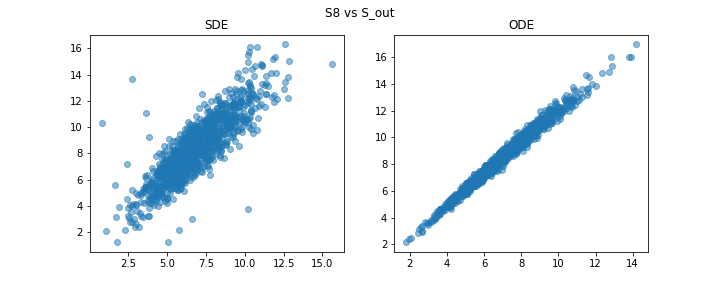

In [28]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].scatter(sde_results['[S8]'], sde_results['[S_out]'], alpha = .5)
ax[0].set_title('SDE')
ax[1].scatter(ode_results['[S8]'], ode_results['[S_out]'], alpha = .5)
ax[1].set_title('ODE')
plt.suptitle('S8 vs S_out')

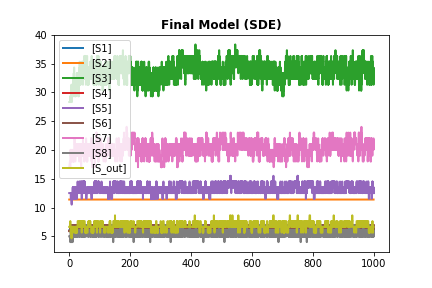

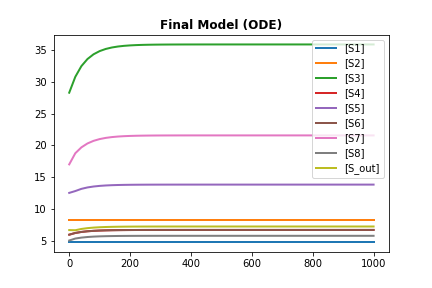

In [44]:
r_8_sim = SimulateData(r_8_species)
r_8_sim.sim_with_species_adj(species_adjust = ['S_in', 'S1', 'S2'], sim_type = 'sde')
sde_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

r_8_sim.sim_with_species_adj(species_adjust = ['S_in', 'S1', 'S2'], sim_type = 'ode')
ode_results = r_8_sim.sim_results
r_8_sim.plot_last_sim()

Text(0.5, 0.98, 'S7 vs S_out')

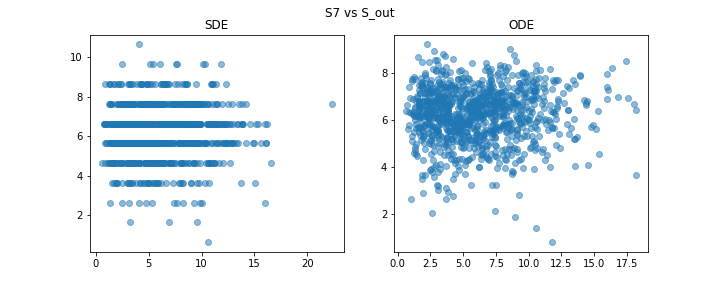

In [45]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].scatter(sde_results['[S2]'], sde_results['[S_out]'], alpha = .5)
ax[0].set_title('SDE')
ax[1].scatter(ode_results['[S2]'], ode_results['[S_out]'], alpha = .5)
ax[1].set_title('ODE')
plt.suptitle('S7 vs S_out')

Text(0.5, 0.98, 'S8 vs S_out')

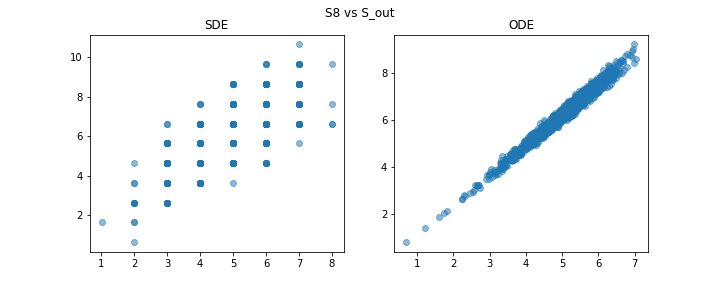

In [46]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].scatter(sde_results['[S8]'], sde_results['[S_out]'], alpha = .5)
ax[0].set_title('SDE')
ax[1].scatter(ode_results['[S8]'], ode_results['[S_out]'], alpha = .5)
ax[1].set_title('ODE')
plt.suptitle('S8 vs S_out')